# Get started

**Fire Opal at a glance and quickstart**

## Fire Opal overview

Fire Opal is a Python package that applies a complete suite of error suppression techniques to vastly improve the quality of quantum algorithm results, often transforming quantum computer outputs from random to useful. For an in-depth explanation of Fire Opal's benefits and capabilities, check out the Fire Opal overview.

This tutorial will run through the steps to set up Fire Opal and use it to run a Bernstein–Vazirani circuit. After completion, you will have demonstrated Fire Opal's benefits by comparing the success probabilities of executing the circuit with both Fire Opal and Qiskit. 

## Setup

### 1. Sign up for an account

You will need to [sign up for a Q-CTRL account](https://q-ctrl.com/fire-opal) to run the Fire Opal package.

### 2. Install Fire Opal Python package

Refer to [how to set up your environment and install Fire Opal](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-set-up-your-environment-and-install-fire-opal) for more detailed information on how to set up your development environment to run Fire Opal. If you already have Python and a package manager installed, you can use the following command to install the necessary packages:

```shell
pip install fire-opal qiskit matplotlib qiskit-ibm-runtime qctrl-visualizer
```

In [19]:
%pip install fire-opal qiskit matplotlib qiskit-ibm-runtime qctrl-visualizer -q
import fireopal as fo
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
import matplotlib.pyplot as plt
import qctrlvisualizer as qv

plt.style.use(qv.get_qctrl_style())

#### 2.1. Specify your organization
If your Q-CTRL account is a member of multiple organizations, you must specify which organization to use by setting the organization parameter, as shown below. You can check organization names and other details by visiting your [Q-CTRL account](https://accounts.q-ctrl.com/). 

If your account details show multiple organizations, replace `organization_slug` with the unique identifier listed in your organization details. 

In [4]:
# Uncomment and replace "organization_slug" if you are a member of multiple Q-CTRL organizations
# fo.config.configure_organization(organization_slug="organization_slug")

# Uncomment and replace "q-ctrl-token" with your API key, which you can find at https://accounts.q-ctrl.com/security
# fo.authenticate_qctrl_account("q-ctrl-token")

### 3. Sign up for an IBM Quantum account
While Fire Opal's techology is inherently backend agnostic, in this tutorial we will run the circuit on an IBM Quantum backend device. 

You will need to [sign up](https://quantum.ibm.com/) for an IBM Quantum account, which you can use to access devices on the Open or Premium IBM Quantum plans. Simply input your hub, group, project, and access token to the [`make_credentials_for_ibmq`](https://docs.q-ctrl.com/references/fire-opal/fireopal/fireopal.credentials.make_credentials_for_ibmq.html) function.

Alternatively, you can [authenticate with IBM Cloud](https://docs.q-ctrl.com/references/fire-opal/fireopal/fireopal.credentials.make_credentials_for_ibmq.html). Visit the documentation for more information on how to [get started](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-get-started).

**Note:** IBM Quantum offers public access to some of their quantum computers. However, queue times for public systems can be long, which will cause delays in the execution steps of this guide (steps 5 and 7). These delays are extraneous to Fire Opal.

## Demo: Running the Bernstein–Vazirani algorithm with Fire Opal

We'll use Fire Opal to run a Bernstein–Vazirani circuit. This algorithm is broadly used to find a string from the outputs of a black box function, though this information is not necessary for the sake of running this example.

### 1. Define helper functions

We will start by defining three helper functions:
- `draw_circuit`: draws our QASM circuit
- `plot_bv_results`: plots the results of our experiments
- `bitstring_count_to_probabilities`: converts bitstring counts to probabilities

In [2]:
shot_count = 2048


def draw_circuit(qasm_str: str):
    """Draws a QASM circuit."""
    circuit = qiskit.QuantumCircuit.from_qasm_str(qasm_str)
    display(circuit.draw(fold=-1))


def plot_bv_results(results, hidden_string, title="", max_columns=None):
    """
    Plot a probability histogram and highlight the hidden string.
    """

    # Restrict the number of columns displayed.
    if max_columns is not None:
        top_strings = sorted(results.keys(), key=lambda x: results[x], reverse=True)[
            :max_columns
        ]
        if hidden_string not in top_strings:
            top_strings.append(hidden_string)
        results = {s: results.get(s, 0) for s in top_strings}

    bitstrings = sorted(results.keys())

    def to_probability(value, total):
        if isinstance(value, float):
            return value
        return value / total

    probabilities = [to_probability(results[b], shot_count) for b in bitstrings]
    plt.figure(figsize=(20, 5))
    bars = plt.bar(bitstrings, probabilities)
    plt.xticks(rotation=90)

    for index, bitstring in enumerate(bitstrings):
        if bitstring != hidden_string:
            bars[index].set_color("grey")

    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.title(title)
    plt.show()


def bitstring_count_to_probabilities(data, shot_count, number_of_counting_qubits):
    """
    Process the results.
    This function turns a dictionary of bitstring counts into a dictionary
    of probabilities.
    """
    probabilities = {
        format(int(bitstring, 2), f"0{number_of_counting_qubits}b"): (
            bitstring_count / shot_count
        )
        for bitstring, bitstring_count in data.items()
    }

    return probabilities

### 2. Provide the quantum circuit

Here, we will define the Bernstein–Vazirani circuit as an [OpenQASM](https://openqasm.com/) string and visualize it using our previously defined helper function `draw_circuit`. Such a string can also be generated by exporting a quantum circuit written with any quantum-specific Python library.

In [11]:
hidden_string = "1111111111111111111"

circuit_qasm = (
    circuit_qasm
) = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[20];
creg c[19];
x q[19];
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];
h q[9];
h q[10];
h q[11];
h q[12];
h q[13];
h q[14];
h q[15];
h q[16];
h q[17];
h q[18];
h q[19];
cx q[0],q[19];
cx q[1],q[19];
cx q[2],q[19];
cx q[3],q[19];
cx q[4],q[19];
cx q[5],q[19];
cx q[6],q[19];
cx q[7],q[19];
cx q[8],q[19];
cx q[9],q[19];
cx q[10],q[19];
cx q[11],q[19];
cx q[12],q[19];
cx q[13],q[19];
cx q[14],q[19];
cx q[15],q[19];
cx q[16],q[19];
cx q[17],q[19];
cx q[18],q[19];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],q[16],q[17],q[18],q[19];
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];
h q[9];
h q[10];
h q[11];
h q[12];
h q[13];
h q[14];
h q[15];
h q[16];
h q[17];
h q[18];
h q[19];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],q[16],q[17],q[18],q[19];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
measure q[8] -> c[8];
measure q[9] -> c[9];
measure q[10] -> c[10];
measure q[11] -> c[11];
measure q[12] -> c[12];
measure q[13] -> c[13];
measure q[14] -> c[14];
measure q[15] -> c[15];
measure q[16] -> c[16];
measure q[17] -> c[17];
measure q[18] -> c[18];"""
draw_circuit(circuit_qasm)

┌───┐                                                                                                     ░ ┌───┐ ░ ┌─┐                                                      
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────░─┤ H ├─░─┤M├──────────────────────────────────────────────────────
      ├───┤       │                                                                                             ░ ├───┤ ░ └╥┘┌─┐                                                   
 q_1: ┤ H ├───────┼────■────────────────────────────────────────────────────────────────────────────────────────░─┤ H ├─░──╫─┤M├───────────────────────────────────────────────────
      ├───┤       │    │                                                                                        ░ ├───┤ ░  ║ └╥┘┌─┐                                                
 q_2: ┤ H ├───────┼────┼────■───────────────────────────────────────────────────────────────────────────────────░─┤ H ├─░──╫──╫─┤M├────────────────────────────────────────────────
      ├───┤       │    │    │                                                                                   ░ ├───┤ ░  ║  ║ └╥┘┌─┐                                             
 q_3: ┤ H ├───────┼────┼────┼────■──────────────────────────────────────────────────────────────────────────────░─┤ H ├─░──╫──╫──╫─┤M├─────────────────────────────────────────────
      ├───┤       │    │    │    │                                                                              ░ ├───┤ ░  ║  ║  ║ └╥┘┌─┐                                          
 q_4: ┤ H ├───────┼────┼────┼────┼────■─────────────────────────────────────────────────────────────────────────░─┤ H ├─░──╫──╫──╫──╫─┤M├──────────────────────────────────────────
      ├───┤       │    │    │    │    │                                                                         ░ ├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐                                       
 q_5: ┤ H ├───────┼────┼────┼────┼────┼────■────────────────────────────────────────────────────────────────────░─┤ H ├─░──╫──╫──╫──╫──╫─┤M├───────────────────────────────────────
      ├───┤       │    │    │    │    │    │                                                                    ░ ├───┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐                                    
 q_6: ┤ H ├───────┼────┼────┼────┼────┼────┼────■───────────────────────────────────────────────────────────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫─┤M├────────────────────────────────────
      ├───┤       │    │    │    │    │    │    │                                                               ░ ├───┤ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                 
 q_7: ┤ H ├───────┼────┼────┼────┼────┼────┼────┼────■──────────────────────────────────────────────────────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────
      ├───┤       │    │    │    │    │    │    │    │                                                          ░ ├───┤ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                              
 q_8: ┤ H ├───────┼────┼────┼────┼────┼────┼────┼────┼────■─────────────────────────────────────────────────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────
      ├───┤       │    │    │    │    │    │    │    │    │                                                     ░ ├───┤ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                           
 q_9: ┤ H ├───────┼────┼────┼────┼────┼────┼────┼────┼────┼────■────────────────────────────────────────────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────
      ├───┤       │    │    │    │    │    │    │    │    │    │                                                ░ ├───┤ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                        
q_10: ┤ H ├───────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■───────────────────────────────────────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────
      ├───┤       │    │    │    │    │    │  

### 3. Provide your device information and credentials

Next, we'll provide device information for the real hardware backend. Fire Opal will execute the circuit on the backend on your behalf, and it is designed to work seamlessly across multiple backend providers. For this example, we will use an IBM Quantum hardware device. 

Note that the code below requires your IBM Quantum API token. Visit [IBM Quantum](https://quantum.ibm.com/) to sign up for an account and obtain your access credentials.

In [ ]:
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_IBM_TOKEN"
credentials = fo.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

service = QiskitRuntimeService(
    token=token, instance=hub + "/" + group + "/" + project, channel="ibm_quantum"
)

Next we will use the function `show_supported_devices` to list the devices that are both supported by Fire Opal and accessible to you when using the `credentials` above.

In [ ]:
supported_devices = fo.show_supported_devices(credentials=credentials)[
    "supported_devices"
]
for name in supported_devices:
    print(name)

From the resulting list, you can choose a backend device and replace `"desired_backend"`. The list will only include devices accessible to you.

In [ ]:
# Enter your desired IBM backend here or select one with a small queue
backend_name = "desired_backend"
print(f"Will run on backend: {backend_name}")

### 4. Validate the circuit and backend

Now that we have defined our credentials and are able to select a device we wish to use, we can validate that Fire Opal can compile our circuit, and that it's compatible with the indicated backend.  

In [ ]:
validate_results = fo.validate(
    circuits=[circuit_qasm], credentials=credentials, backend_name=backend_name
)

if validate_results["results"] == []:
    print("No errors found.")
else:
    print("The following errors were found:")
    for error in validate_results["results"]:
        print(error)

In this previous example, the output should be an empty list since there are no errors in the circuit, i.e. `validate_results["results"] == []`. 
Note that the length of the `validate_results` list is the total number of errors present across all circuits in a batch.
Since our circuit is error free, we can execute our circuit on real hardware.

### 5. Execute the circuit using Fire Opal

In the absence of hardware noise, only a single experiment would be required to obtain the correct hidden string: `111 111 111 11`. However in real quantum hardware, noise disturbs the state of the system and degrades performance, decreasing the probability of obtaining the correct answer for any single experiment. Fire Opal automates the adjustments made by experts when running circuits on a real device.

**_Note: Once jobs are submitted, there may be a delay in returning results due to the hardware provider's queue. You can [view and retrieve results later](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-view-previous-jobs-and-retrieve-results). Be sure to let your jobs finish executing, and do not cancel the process. Even in the case of kernel disconnection, the job will still complete, and results can later be retrieved._** 

In [ ]:
fire_opal_job = fo.execute(
    circuits=[circuit_qasm],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
)

In [ ]:
bitstring_results = fire_opal_job.result()["results"]

### 6. Analyze results

Now you can look at the outputs from the quantum circuit executions. The success probability is simply the number of times the hidden string was obtained out of the total number of circuit shots. For reference, running this circuit on a real device without Fire Opal typically has a success probability of 2-3%. As you can see, Fire Opal greatly improved the success probability.

Success probability: 22.93%


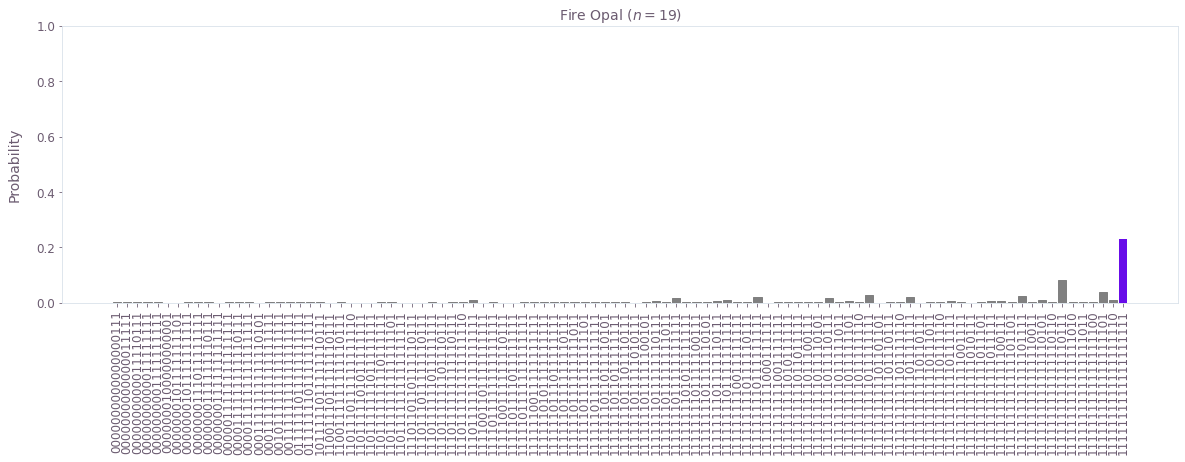

In [21]:
print(f"Success probability: {100 * bitstring_results[0][hidden_string]:.2f}%")
plot_bv_results(
    bitstring_results[0],
    hidden_string=hidden_string,
    title=f"Fire Opal ($n=19$)",
    max_columns=100,
)

### 7. Compare Fire Opal Results with Qiskit

To get a true comparison, let's run the same circuit without Fire Opal. We'll run the circuit using Qiskit on the same IBM backend as used previously to get a one-to-one comparison.

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = service.backend(backend_name)
sampler = Sampler(backend=backend)

circuit_qiskit = qiskit.QuantumCircuit.from_qasm_str(circuit_qasm)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pass_manager.run(circuit_qiskit)
ibm_result = sampler.run([isa_circuit], shots=shot_count).result()
ibm_probabilities = bitstring_count_to_probabilities(
    ibm_result[0].data.c.get_counts(), shot_count, 19
)

Success probability: 0.39%


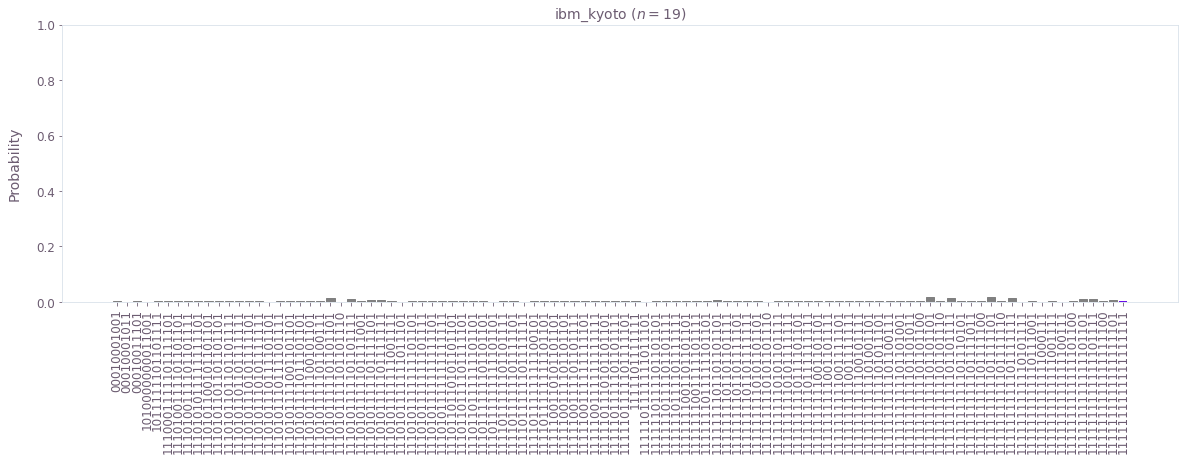

In [27]:
print(f"Success probability: {100 * ibm_probabilities[hidden_string]:.2f}%")
plot_bv_results(
    ibm_probabilities,
    hidden_string=hidden_string,
    title=f"{backend_name} ($n=19$)",
    max_columns=100,
)

The above results demonstrate that noise has severely impacted the probability of obtaining the correct hidden string as the output. In this case, the string returned with the greatest frequency by the quantum computer was not the expected `111 111 111 11` state. We should also take note of the amount of incorrect states that now contain non-zero return probabilities. Not only do default configurations fail to find the correct answer, they also increase the probabilities of the incorrect answers.

In fact, the performance degradation is so severe that in order to be reasonably sure of the hidden string, using the original classical algorithm would be more efficient.

You can tell that Fire Opal found the correct answer because the mode of the output distribution, or the most frequent outcome, matches the desired output: bitstring `111 111 111 11`. Fire Opal significantly improves the probability of a successful outcome, often by a factor of ten or more.

In [31]:
fire_opal_success = bitstring_results[0][hidden_string]
ibm_success = ibm_probabilities[hidden_string]

if ibm_success != 0:
    factor = fire_opal_success / ibm_success
    print(f"Fire Opal improved success probability by a factor of {int(factor)}!")
else:
    print("Fire Opal improved success probability by a factor of >1000X")

Fire Opal improved success probability by a factor of 58!


Congratulations! You've run your first algorithm with Fire Opal and demonstrated its ability in transforming a device which finds the incorrect answer by default, to a device that finds the correct answer.

The package versions below were used to produce this notebook.

In [3]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.11.8  |
| matplotlib            | 3.8.4   |
| networkx              | 2.8.8   |
| numpy                 | 1.26.4  |
| qiskit                | 1.0.2   |
| qiskit-ibm-runtime    | 0.23.0  |
| sympy                 | 1.12    |
| fire-opal             | 7.2.0   |
| qctrl-workflow-client | 3.0.0   |
